In [1]:
from skimage.io import imread
import napari
import pyclesperanto_prototype as cle
import numpy as np

#print decimals with precision of 3
np.set_printoptions(precision=3)

#Read lattice tiff file
rbc = imread("E:\\Python_Repos\\RAPA_treated-01-Raw_Zeiss.tif")

voxel_size_x = 0.1449922
voxel_size_y = 0.1449922
voxel_size_z = 0.3

angle_in_degrees = 30

rbc.shape

(501, 140, 1488)

In [2]:
import math 
transform = cle.AffineTransform3D()
shear_factor = math.sin((90 - angle_in_degrees) * math.pi / 180.0) * (voxel_size_z/voxel_size_y)
transform._matrix[1, 2] = shear_factor


(501, 1037, 1488)
After shearing


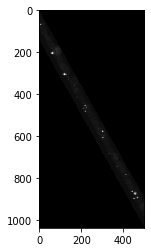

In [3]:
shear_transformed_img = cle.affine_transform(source= rbc,transform = transform,auto_size=True)
print(shear_transformed_img.shape)
print("After shearing")
cle.imshow(cle.maximum_x_projection(shear_transformed_img))

(518, 1037, 1488)
After shearing and scaling


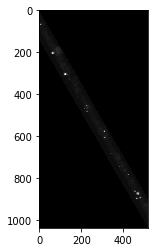

In [4]:
new_dz = math.sin(angle_in_degrees * math.pi / 180.0) * voxel_size_z
scale_factor_z = (new_dz / voxel_size_y) * 1
transform.scale(scale_x=1, scale_y=1, scale_z=scale_factor_z)

shear_transformed_img = cle.affine_transform(source= rbc,transform = transform,auto_size=True)
print(shear_transformed_img.shape)
print("After shearing and scaling")
cle.imshow(cle.maximum_x_projection(shear_transformed_img))

(70, 1157, 1488)
After shearing, scaling and rotation


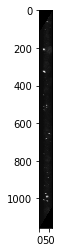

In [5]:
transform.rotate(angle_in_degrees= 0 - angle_in_degrees, axis=0)

shear_transformed_img = cle.affine_transform(source= rbc,transform = transform,auto_size=True)
print(shear_transformed_img.shape)
print("After shearing, scaling and rotation")
cle.imshow(cle.maximum_x_projection(shear_transformed_img))

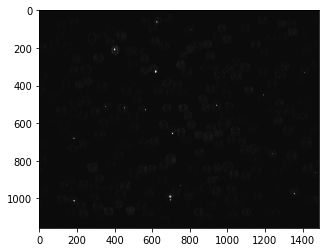

In [6]:
cle.imshow(cle.maximum_z_projection(shear_transformed_img))

In [14]:
cropped_vol = rbc[44:118,0:139,374:433]

(69, 273, 59)
After shearing, scaling and rotation


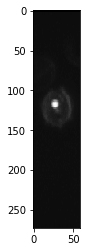

In [15]:
crop_transformed_img = cle.affine_transform(source= cropped_vol,transform = transform,auto_size=True)
print(crop_transformed_img.shape)
print("After shearing, scaling and rotation")
cle.imshow(cle.maximum_z_projection(crop_transformed_img))

In [16]:
def _deskew_y_vol_transform(original_volume, angle_in_degrees:float = 30, voxel_size_x: float = 1,
              voxel_size_y: float = 1, voxel_size_z: float = 1, scale_factor: float = 1):
    """Return deskew transform for specified volume
       Rotation is performed around centre of "original_volume"
    Args:
        crop ([type]): Volume to deskew (zyx)
        original_volume ([type]): Reference volume around with to perform rotation (zyx)
        angle_in_degrees (float): Deskewing angle
        voxel_size_x (float, optional): [description]. Defaults to 1.
        voxel_size_y (float, optional): [description]. Defaults to 1.
        voxel_size_z (float, optional): [description]. Defaults to 1.
        scale_factor (float, optional): [description]. Defaults to 1.

    Returns:
        cle.AffineTransform3D
    """    
    import math
    
    transform = cle.AffineTransform3D()
    shear_factor = math.sin((90 - angle_in_degrees) * math.pi / 180.0) * (voxel_size_z/voxel_size_y)
    transform._matrix[1, 2] = shear_factor

    # make voxels isotropic, calculate the new scaling factor for Z after shearing
    # https://github.com/tlambert03/napari-ndtiffs/blob/092acbd92bfdbf3ecb1eb9c7fc146411ad9e6aae/napari_ndtiffs/affine.py#L57
    new_dz = math.sin(angle_in_degrees * math.pi / 180.0) * voxel_size_z
    scale_factor_z = (new_dz / voxel_size_y) * scale_factor
    transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
    
    #rotation around centre of ref_vol
    #transform._concatenate(rotate_around_vol_mat(original_volume, (0-angle_in_degrees)))
    transform.rotate(angle_in_degrees= 0 - angle_in_degrees, axis=0)
    # correct orientation so that the new Z-plane goes proximal-distal from the objective.

    return transform

#Calculate rotation transform around a volume
def rotate_around_vol_mat(ref_vol,angle_in_degrees:float=30.0):
    """Return the rotation matrix , so its rotated around centre of ref_vol

    Args:
        ref_vol (tuple): Shape of the ref volume (zyx)
        angle_in_degrees (float, optional): [description]. Defaults to 30.0.

    Returns:
        Rotation matrix: Will be returned in the form xyz for clesperanto affine transforms
    """    
    angle_in_rad = angle_in_degrees * np.pi / 180.0
    #rotate_transform = cle.AffineTransform3D()
    #rotate_transform._matrix
    # first translate the middle of the image to the origin
    nz,ny,nx = ref_vol.shape
    T1 = np.array([
            [1, 0, 0, nx / 2],
            [0, 1, 0, ny / 2],
            [0, 0, 1, nz / 2],
            [0, 0, 0, 1]
            ])

    R = np.array([
                [1, 0, 0, 0],
                [0, np.cos(angle_in_rad), np.sin(angle_in_rad), 0],
                [0, -np.sin(angle_in_rad), np.cos(angle_in_rad),0],
                [0, 0, 0, 1]
                ])
                
    T2 = np.array([
            [1, 0, 0, -nx / 2],
            [0, 1, 0, -ny / 2],
            [0, 0, 1, -nz / 2],
            [0, 0, 0, 1]
            ])
    T = np.eye(4)
    rotate_mat = np.dot(np.dot(np.dot(T, T1), R), T2)
    #print(rotate_mat)
    return rotate_mat

In [17]:
deskew_crop_transform = _deskew_y_vol_transform(rbc,30,voxel_size_x,voxel_size_y,voxel_size_z)
deskew_crop_transform._matrix


array([[ 1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  8.660e-01,  2.069e+00,  0.000e+00],
       [ 0.000e+00, -5.000e-01,  1.110e-16,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00]])

(69, 273, 59)
After shearing, scaling and rotation


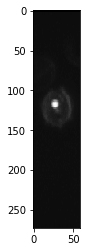

In [18]:
crop_transformed_img = cle.affine_transform(source= cropped_vol,transform = deskew_crop_transform,auto_size=True)
print(crop_transformed_img.shape)
print("After shearing, scaling and rotation")
cle.imshow(cle.maximum_z_projection(crop_transformed_img))

In [20]:
import napari 
viewer = napari.Viewer()


C:\Users\Pradeep\.conda\envs\llsz\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [21]:
viewer.add_image(crop_transformed_img)

<Image layer 'crop_transformed_img' at 0x26d538e5130>